In [ ]:
!pip install -q underthesea

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.naive_bayes import *
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.under_sampling import RandomUnderSampler
import re
import pickle
from underthesea import word_tokenize
import random as rand
from wordcloud import WordCloud
from gensim.parsing.preprocessing import *
import nltk
from gensim.models import KeyedVectors
import time

In [ ]:
# Chọn thư mục hoạt động

%cd /content/drive/MyDrive/AI/NLP

/content/drive/MyDrive/AI/NLP


In [ ]:
# Tạo các thư mục liên quan
!rm -rf imgs/vis_spam_detection/
!rm -rf models/vis_spam_detection/
!rm -rf logs/vis_spam_detection/

!mkdir -p datasets/vis_spam_detection/
!mkdir -p imgs/vis_spam_detection/
!mkdir -p models/vis_spam_detection/
!mkdir -p logs/vis_spam_detection/

In [ ]:
# Thiết lập chung

ds_path = 'datasets/vis_spam_detection/'
img_path = 'imgs/vis_spam_detection/'
model_path = 'models/vis_spam_detection/'
log_path = 'logs/vis_spam_detection/'

In [ ]:
# Tải tập dữ liệu từ Git

!rm -f vispamdetection_dataset.zip
!wget -nc https://raw.githubusercontent.com/sonlam1102/vispamdetection/main/dataset/vispamdetection_dataset.zip
!mv vispamdetection_dataset.zip $ds_path

--2024-08-01 16:49:16--  https://raw.githubusercontent.com/sonlam1102/vispamdetection/main/dataset/vispamdetection_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1156542 (1.1M) [application/zip]
Saving to: ‘vispamdetection_dataset.zip’

vispamdetection_dat 100%[===================>]   1.10M  --.-KB/s    in 0.08s   

2024-08-01 16:49:16 (13.3 MB/s) - ‘vispamdetection_dataset.zip’ saved [1156542/1156542]



In [ ]:
# Tải bộ stopwords vietnamese từ Git

!wget -nc https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt
!mv vietnamese-stopwords.txt $ds_path

--2024-08-01 16:49:16--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘vietnamese-stopwords.txt’

vietnamese-stopword 100%[===================>]  20.00K  --.-KB/s    in 0.003s  

2024-08-01 16:49:16 (7.77 MB/s) - ‘vietnamese-stopwords.txt’ saved [20475/20475]



In [ ]:
# Giải nén tập dữ liệu

!7z x {ds_path}vispamdetection_dataset.zip -o{ds_path}
!ls {ds_path}


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1156542 bytes (1130 KiB)

Extracting archive: datasets/vis_spam_detection/vispamdetection_dataset.zip
--
Path = datasets/vis_spam_detection/vispamdetection_dataset.zip
Type = zip
Physical Size = 1156542

  0%    
Would you like to replace the existing file:
  Path:     datasets/vis_spam_detection/dataset/test.csv
  Size:     666251 bytes (651 KiB)
  Modified: 2024-07-23 10:39:52
with the file from archive:
  Path:     dataset/test.csv
  Size:     666251 bytes (651 KiB)
  Modified: 2021-10-20 23:37:34
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? S

 20%    Everything is Ok

Files: 0
Size:       0
Compressed: 1156542
dataset      vietnamese-stopwords.txt	  word2vec_vi_words_100d

#### Nạp dữ liệu

In [ ]:
# Nạp dữ liệu vào bộ nhớ

train_df = pd.read_csv(os.path.join(ds_path, 'dataset/train.csv'), delimiter=',')
test_df = pd.read_csv(os.path.join(ds_path, 'dataset/test.csv'), delimiter=',')

dev_df = pd.read_csv(os.path.join(ds_path, 'dataset/dev.csv'), delimiter=',')

# Hợp nhất 2 df train & test
df = pd.concat([train_df, test_df], ignore_index=True)
df

,Rating,Comment,Label,SpamLabel
0,5,"Chất lượng sản phẩm tuyệt vời, má",0,0
1,5,Jdjd is a waste of my time and place to ask qu...,1,3
2,5,Dhnxncbcncncncncnncncncnncncncncncncncnncncncj...,1,3
3,5,"giao hàng nhanh, đóng gói cẩn thận, sản phẩm n...",0,0
4,3,Bạt mỏng vs lại không có túi đi kèm để cất khi...,0,0
...,...,...,...,...
18275,5,Sản phẩm OK rất đẹp !cảm ơn Shop Sp rẻ mà rất ...,0,0
18276,5,Rêu được lấy từ rừng về đã rửa sạch đất cát rồ...,1,3
18277,5,Shop giao hàng nhanh nhưng mỗi tội cái shopee ...,1,2
18278,5,Shop ơi em có đặt 2 ram 8g dr4 nhưng máy em nh...,1,3


In [ ]:
# Liệt kê tên các cột

df.columns

Index(['Rating', 'Comment', 'Label', 'SpamLabel'], dtype='object')

In [ ]:
# Lược bỏ các cột dư thừa

df = df[['Comment', 'Label']]
df.columns

Index(['Comment', 'Label'], dtype='object')

In [ ]:
# Đổi tên các cột cho dễ nhận biết

df = df.rename(columns={'Comment': 'text', 'Label': 'label'})
df.columns

Index(['text', 'label'], dtype='object')

In [ ]:
# Kiểm tra giá trị N/A

df.isna().sum()

,0
text,0
label,0


#### Tiền xử lý thuộc tính Label

In [ ]:
# Liệt kê các giá trị duy nhất

df['label'].unique()

array([0, 1])

label
0    13452
1     4828
Name: count, dtype: int64


<Axes: xlabel='label'>

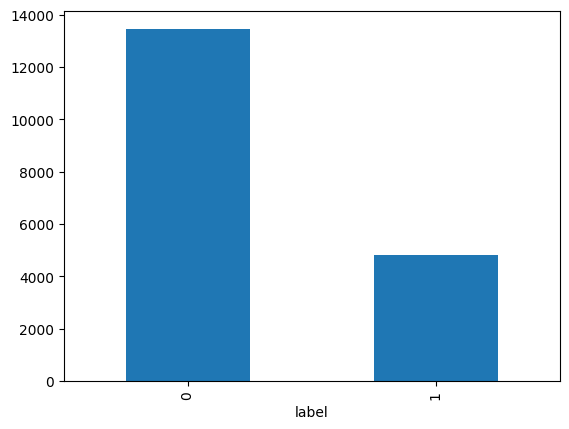

In [ ]:
# Kiểm tra cân bằng nhãn

print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar')

label
0    4828
1    4828
Name: count, dtype: int64


<Axes: xlabel='label'>

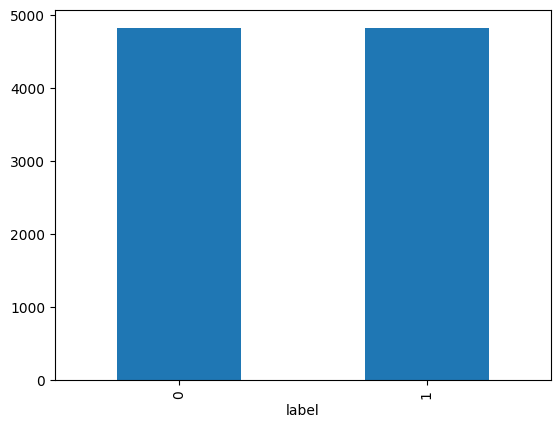

In [ ]:
# Tái cân bằng nhãn bằng under-sample

rus = RandomUnderSampler(random_state=42)
df, df['label'] = rus.fit_resample(df, df['label'])
df.reindex()

print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar')

In [ ]:
# Tạo lớp cho thuộc tính label

classes = ['not spam', 'spam']

#### Tiền xử lý thuộc tính Text

In [ ]:
# Tải danh mục stopword vietnamese
stop_words_vi = set()

with open(os.path.join(ds_path, 'vietnamese-stopwords.txt'), 'r') as f:
  for line in f:
    stop_words_vi.add(line.strip())

list(stop_words_vi)[:5]

['cho nhau', 'nếu không', 'giống người', 'lấy ráo', 'cả nghe']

In [ ]:
# Tiền xử lý chuỗi

def text_preprocessing(text):
  """
  Tiền xử lý chuỗi
  """
  # Chuyển chữ thường
  text = text.lower()
  # Loại bỏ URL
  text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)
  # Loại bỏ html tag
  text = strip_tags(text)
  # Loại bỏ emoji
  text = strip_non_alphanum(text)
  # Loại bỏ các số
  text = strip_numeric(text)
  # Loại bỏ chuỗi nếu sau 10 kí tự liên tục mà không có khoảng trắng
  text = re.sub(r'\b\w{10,}\b', '', text)
  # Loại bỏ các từ dừng Tiếng Việt
  text = ' '.join([word for word in text.split() if word not in stop_words_vi])
  # Lược bỏ dấu câu & emoji tiếng Việt
  #text = text.encode('ascii', 'ignore').decode('utf-8')
  # Loại bỏ các từ dừng tiếng Anh
  text = remove_stopwords(text)
  # Loại bỏ khoảng trắng thừa
  text = strip_multiple_whitespaces(text)
  return text

demo = df['text'][0]
print(text_preprocessing(demo))

chất sản phẩm tuyệt vời má


In [ ]:
df['text'] = df['text'].apply(text_preprocessing)
df

,text,label
10111,shop mắc cười lắm giao vận kêu giao hủy đơn đi...,0
4131,balo giá rẻ màu hình chất tạm đường yếu thừa,0
3656,hàng quốc tế ship siêu hàng giao hàng đóng gói...,0
987,mua hàng tiki trading tâm nguyên seal đồng hồ ...,0
14211,giao hàng đóng gói sản phẩm chắn chất sản phẩm,0
...,...,...
18267,qc soan y gui ban se nhan gb data g toc phut g...,1
18272,giao hàng đóng gói đẹp giao hàng chất video tc xu,1
18276,rêu rừng rửa sạch đất cát phơi khô nhẹ rải lớp...,1
18277,shop giao hàng tội shopee express vớ vẩn vận h...,1


In [ ]:
# Áp dụng tokenization cho cột 'text'

df['tokens'] = df['text'].apply(word_tokenize)

In [ ]:
# Tải mô hình Word2vec đã pretrained PhoW2V

!wget -nc 'https://public.vinai.io/word2vec_vi_words_100dims.zip' -P {ds_path}
!7z x {ds_path}word2vec_vi_words_100dims.zip -o{ds_path}
!ls {ds_path}

--2024-08-01 17:03:05--  https://public.vinai.io/word2vec_vi_words_300dims.zip
Resolving public.vinai.io (public.vinai.io)... 108.159.227.61, 108.159.227.26, 108.159.227.34, ...
Connecting to public.vinai.io (public.vinai.io)|108.159.227.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2315583928 (2.2G) [application/zip]
Saving to: ‘datasets/vis_spam_detection/word2vec_vi_words_300dims.zip’

word2vec_vi_words_3 100%[===================>]   2.16G  18.8MB/s    in 2m 1s   

2024-08-01 17:05:07 (18.3 MB/s) - ‘datasets/vis_spam_detection/word2vec_vi_words_300dims.zip’ saved [2315583928/2315583928]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 785783878 bytes (750 MiB)

Extracting archive: datasets/vis_spam_detection/word2vec_vi_words_100

In [ ]:
# Vecto hóa văn bản để đưa vào mô hình ML (Word2Vec)

sentences = df['tokens'].tolist()
vec_model = KeyedVectors.load_word2vec_format(os.path.join(ds_path, 'word2vec_vi_words_100dims.txt'), binary=False)

def text_to_vector(text):
  vectors = []
  words = text.split()
  for word in words:
    if word in vec_model:
      vectors.append(vec_model[word])
  if vectors:
    return np.mean(vectors, axis=0)
  else:
    return np.zeros(vec_model.vector_size)

text_vectorized = np.array([text_to_vector(text) for text in df['text']])

In [ ]:
# Hợp nhất x, y

x = text_vectorized
y = df['label']

print(x.shape, y.shape)

(9656, 100) (9656,)


#### Đào tạo mô hình & dự đoán

In [ ]:
# Tách tập dữ liệu Train/Test

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.25, random_state=42, stratify=y
)

print('Train:',x_train.shape[0])
print('Test:',x_test.shape[0])

Train: 7242
Test: 2414


Time for fit: 1.800832986831665
DecisionTreeClassifier() 0.648301574150787
              precision    recall  f1-score   support

           0       0.65      0.66      0.65      1207
           1       0.65      0.64      0.64      1207

    accuracy                           0.65      2414
   macro avg       0.65      0.65      0.65      2414
weighted avg       0.65      0.65      0.65      2414



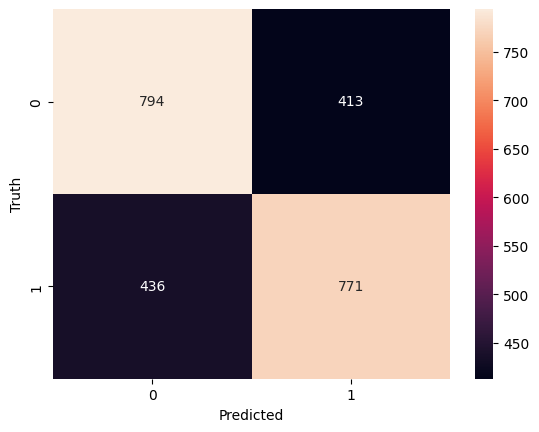

Time for fit: 13.225385427474976
RandomForestClassifier() 0.7526926263463132
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1207
           1       0.77      0.71      0.74      1207

    accuracy                           0.75      2414
   macro avg       0.75      0.75      0.75      2414
weighted avg       0.75      0.75      0.75      2414



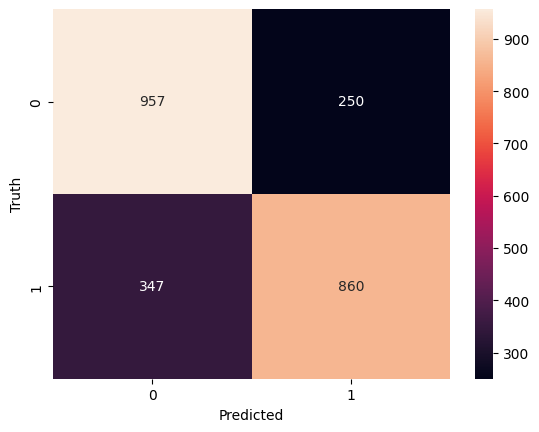

Time for fit: 0.1110837459564209
LogisticRegression() 0.7009113504556752
              precision    recall  f1-score   support

           0       0.68      0.75      0.72      1207
           1       0.72      0.65      0.68      1207

    accuracy                           0.70      2414
   macro avg       0.70      0.70      0.70      2414
weighted avg       0.70      0.70      0.70      2414



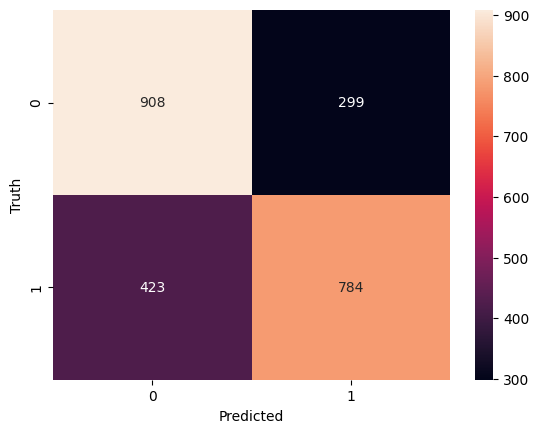

Time for fit: 0.014118194580078125
GaussianNB() 0.6727423363711682
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      1207
           1       0.76      0.51      0.61      1207

    accuracy                           0.67      2414
   macro avg       0.69      0.67      0.66      2414
weighted avg       0.69      0.67      0.66      2414



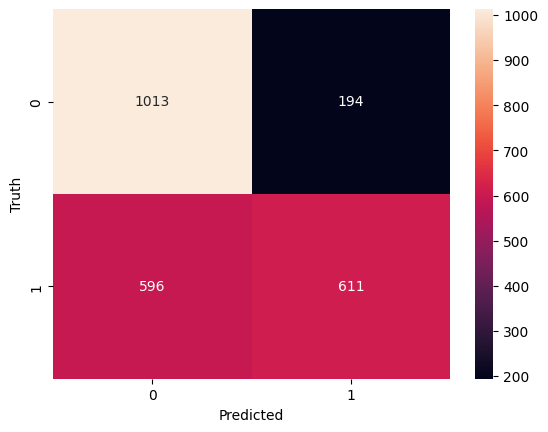

Time for fit: 0.020514249801635742
BernoulliNB() 0.6743993371996686
              precision    recall  f1-score   support

           0       0.62      0.88      0.73      1207
           1       0.80      0.47      0.59      1207

    accuracy                           0.67      2414
   macro avg       0.71      0.67      0.66      2414
weighted avg       0.71      0.67      0.66      2414



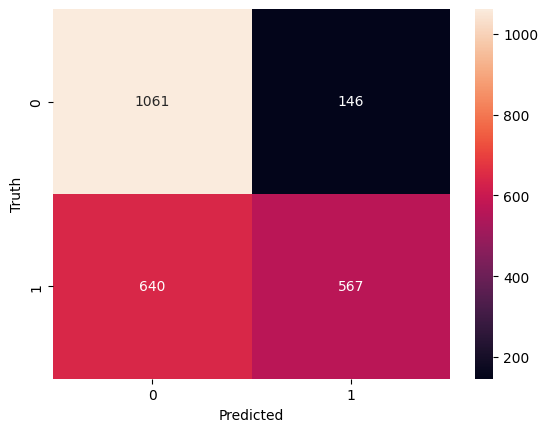

==> Best model: RandomForestClassifier() 0.7526926263463132


In [ ]:
# Đào tạo & lựa chọn mô hình tốt nhất
accuracy_models = {}
accuracy_models.clear()

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    GaussianNB(),
    BernoulliNB()
]

def draw_heat_map(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.show()

for model in models:
  start_time = time.time()
  model.fit(x_train, y_train)
  end_time = time.time()
  print('Time for fit:', end_time - start_time)

  y_pred = model.predict(x_test)
  acc = accuracy_score(y_test, y_pred)
  print(model, acc)
  accuracy_models[model] = accuracy_score(y_test, y_pred)
  print(classification_report(y_test, y_pred))

  # Vẽ ma trận nhầm lẫn
  draw_heat_map(y_test, y_pred)

# Lưu mô hình tốt nhất
best_model = max(accuracy_models, key=accuracy_models.get)
print('==> Best model:',best_model, accuracy_models[best_model])

In [ ]:
# Xuất mô hình

with open(os.path.join(model_path, 'vis_spam_detection_model.pkl'), 'wb') as f:
  pickle.dump(best_model, f)

In [ ]:
# Dự đoán mẫu dữ liệu mới

input_texts = [
    "Tui không thích sản phẩm này!!!",
    "We have detected suspicious activity on your Wells Fargo account. Log in at [Link] to update your account preferences and protect your information",
    "Hi Grandpa, it’s me – I’ve been in a car accident, and my parents aren’t around. Can you please send me money so I can get home? You can wire funds to me here: [Link]",
    "Hey, it's [Boss Name]. I'm in a meeting now and need your help with something urgent. Can you transfer $5,000 to this account ASAP? I'll explain everything later. Please keep this confidential.",
    "Congratulations! You have all been selected to receive a free gift card worth $1000. Click on this link [Link] to claim your reward now. Limited time offer, so act fast! Don't miss out on this amazing opportunity.",
    'Most people are painfully familiar with messages requesting assistance for a family member; these sorts of ruses flooded email inboxes in the early 2000s. Unfortunately, the long-running scam has leaked over to text. It may look something like this:“Your niece has been arrested and needs $7,500.”This is a particularly malicious form of phishing, as it plays into peoples vulnerabilities and prompts impulsive actions. If you receive a message of this kind, refrain from replying and instead contact your relatives for verification.',
    'qc soan gui ban se nhan gb data g toc phut goi',
    'Tôi muốn mua %& mới',
    'Hàng này công nhận # mlem thịt hen 123jds#'
    ]

for pred_text in input_texts:
  pred_text_preprocessed = text_preprocessing(pred_text)
  pred_text_vectorized = text_to_vector(pred_text_preprocessed).reshape(1, -1)
  result = best_model.predict(pred_text_vectorized)
  print('Input:', pred_text)
  print('Input preprocessed:', pred_text_preprocessed)
  print('Output:',classes[result[0]])
  print('\n')

Input: Tui không thích sản phẩm này!!!
Input preprocessed: tui sản phẩm
Output: not spam


Input: We have detected suspicious activity on your Wells Fargo account. Log in at [Link] to update your account preferences and protect your information
Input preprocessed: detected activity wells fargo account log link update account protect
Output: spam


Input: Hi Grandpa, it’s me – I’ve been in a car accident, and my parents aren’t around. Can you please send me money so I can get home? You can wire funds to me here: [Link]
Input preprocessed: hi grandpa s ve car accident parents aren t send money home wire funds link
Output: spam


Input: Hey, it's [Boss Name]. I'm in a meeting now and need your help with something urgent. Can you transfer $5,000 to this account ASAP? I'll explain everything later. Please keep this confidential.
Input preprocessed: hey s boss m meeting need help urgent transfer account asap ll explain later
Output: spam


Input: Congratulations! You have all been selected t